In [1]:
import random
import textwrap
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import HBox, widgets


In [2]:
import tiktoken

encoder = tiktoken.encoding_for_model("gpt-4o")


def count_tokens(text: str) -> int:
    return len(encoder.encode(text))

In [3]:
df = pd.read_json('results/results-hated-fore.jsonl', lines=True)
print(len(df))
df.head()

100


,id,n_hops,answer,hops,predicted_answer,reference_answers,exact_match,f1,fuzzy_match
0,nfl_1703-3a00b508-4c51-400b-9384-b07a5a3d9243,0,Geno Hayes and Aqib Talib each returned interc...,[{'question': 'Which players returned an inter...,Geno Hayes and Aqib Talib each returned interc...,"[Geno Hayes returning an interception, 41 yard...",0,0.400000,0
1,nfl_3018-762534df-e45d-4fa6-a52f-f42aca01da50,0,The Eagles played 16 games in the season.,[{'question': 'How many games did Eagles play ...,The Eagles played 16 games in the season.,[11],0,0.000000,0
2,nfl_1820-fc25086b-04e2-4fcb-add9-55f71eadfa46,0,32 yards.,[{'question': 'How many yards longer was David...,32 yards.,[32],0,0.666667,0
3,nfl_817-f70fdd88-3525-4d9f-b647-cf4ac374126b,0,Jeff Wilkins and Joe Nedney each scored at lea...,[{'question': 'Which players scored at least t...,Jeff Wilkins and Joe Nedney each scored at lea...,"[Jeff Wilkins, Joe Nedney]",0,0.500000,0
4,nfl_3030-26e97c4e-769b-4731-8256-3f7d1d47013a,0,6 points.,[{'question': 'How many points did the Bengals...,6 points.,[6],0,0.666667,0


In [4]:
row = df.iloc[0]
row['hops'][0]

{'question': 'Which players returned an interception for a touchdown?',
 'query': 'Which players returned an interception for a touchdown?',
 'retrieved_docs': [{'text': "# \nThe Cardinals' seventh game was an NFC duel with the Buccaneers at University of Phoenix Stadium. In the first quarter the Cardinals took the lead when QB Max Hall made a 3-yard TD pass to WR Larry Fitzgerald. The Buccaneers replied with OLB Geno Hayes returning an interception 41 yards for a touchdown. The Cardinals led again in the second quarter with RB Beanie Wells getting a 1-yard TD run, but the Buccaneers went on a scoring rally with QB Josh Freeman making a 47-yard TD pass to WR Mike Williams, and CB Aqib Talib returning an interception 45 yards for a touchdown. This was followed by kicker Connor Barth hitting a 21-yard field goal, and in the third quarter with RB LeGarrette Blount getting a 15-yard TD run. The Cardinals also went on a rally to take the lead back with RB LaRod Stephens-Howling making a 30-

In [5]:
df['generation'] = df['hops'].apply(lambda x: x[0]['qa_result']['generation'])
df['gen_token_count'] = df['generation'].apply(lambda x: count_tokens(x))

In [6]:
success_mask = df['f1'] > 0.5
fail_df = df[~success_mask]
success_df = df[success_mask]
print("Fail:", len(fail_df))
print("Success:", len(success_df))
print("Total:", len(df))
print("Mean F1:", f"{df['f1'].mean():.3f}")

Fail: 59
Success: 41
Total: 100
Mean F1: 0.414


In [7]:
answered_mask = df['generation'].str.lower().str.contains('answer:')
len(df.loc[~answered_mask]), f"{len(df.loc[~answered_mask]) / len(df):.3f}"

(18, '0.180')

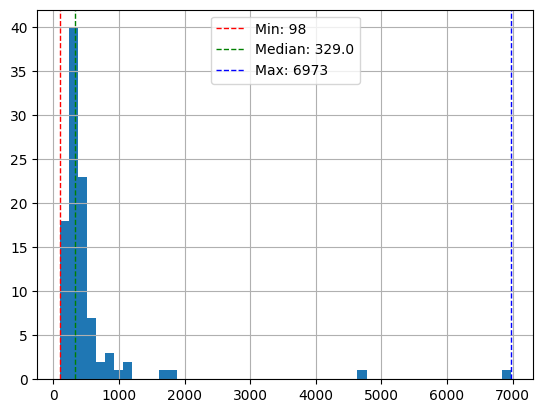

In [8]:
# Plot the histogram
ax = df['gen_token_count'].hist(bins=50)

# Add lines for min, median, and max
min_val = df['gen_token_count'].min()
median_val = df['gen_token_count'].median()
max_val = df['gen_token_count'].max()

plt.axvline(min_val, color='r', linestyle='dashed', linewidth=1, label=f'Min: {min_val}')
plt.axvline(median_val, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_val}')
plt.axvline(max_val, color='b', linestyle='dashed', linewidth=1, label=f'Max: {max_val}')

# Add legend
plt.legend()

# Show plot
plt.show()

In [9]:
def fixedwidth(text):
    return "\n".join(textwrap.wrap(text, width=80, replace_whitespace=False))

def format_row(row):
    context = row['hops'][0]['context']
    question = row['hops'][0]['question']
    generation = row['hops'][0]['qa_result']['generation']

    output = []
    output.append(f"{row['id']} - {row['n_hops']} hops")
    output.append("="*80)
    output.append(fixedwidth(context))
    output.append("="*80)
    output.append("Q: " + question)
    output.append("Reference Answers: " + str(row['reference_answers']))
    output.append("Predicted Answer: " + row['predicted_answer'])
    output.append("-"*80)
    output.append("Generation")
    output.append("-"*80)
    output.append(generation)
    output.append("-"*80)
    output.append("# Scores")
    output.append("EM: {:.3f}".format(row['exact_match']))
    output.append("F1: {:.3f}".format(row['f1']))
    if 'analysis' in row:
        output.append("")
        output.append("# Analysis")
        output.append(fixedwidth(row['analysis']))
    return "\n".join(output)

def present_row(row):
    print(format_row(row))


def create_browse_app(df):
    def browse_failed(i=0):
        row = df.iloc[i]
        present_row(row)

    index = widgets.IntText(value=0, description='Index:')
    left_button = widgets.Button(description='Previous')
    right_button = widgets.Button(description='Next')

    def on_left_button_clicked(b):
        if index.value > 0:
            index.value -= 1

    def on_right_button_clicked(b):
        if index.value < len(df) - 1:
            index.value += 1

    left_button.on_click(on_left_button_clicked)
    right_button.on_click(on_right_button_clicked)

    ui = HBox([left_button, index, right_button])
    out = widgets.interactive_output(browse_failed, {'i': index})

    display(ui, out)


In [10]:
inspect_df = fail_df.sort_values('f1')
create_browse_app(inspect_df)

Output()

In [11]:
unanswered_df = df.loc[~answered_mask]
create_browse_app(unanswered_df)

Output()

In [12]:
answered_failed_df = df.loc[answered_mask & ~success_mask]
create_browse_app(answered_failed_df)

Output()